# SEQ ROI analysis Lag & Corrincorr


In [1]:
import os
import numpy as np
import nibabel as nib
from scipy.stats import f
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import nipype.pipeline.engine as pe
import nipype.interfaces.io as nio
import nipype.interfaces.freesurfer as fs
import nipype.interfaces.utility as util
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from os.path import isfile, exists
import xlrd
Z = norm.ppf


%matplotlib inline

ImportError: No module named builtins

In [ ]:
#We import the impoartant things that we need
import nipype.pipeline as pe
import nipype.interfaces.io as nio
import os
import nipype.interfaces.freesurfer as fs
from nipype import IdentityInterface

#Set up directories we will refer to later
subjects_dir = '/home/data/madlab/surfaces/seqtrd' 
work_dir = '/scratch/madlab/seqtrd/regions_workdir'
sink_dir = '/home/data/madlab/data/mri/seqtrd/mask/783143'

#participants we will be iterating over
sids = ['783143']

#sids = ['783125', '783126', '783127', '783128', '783129', '783130', '783131', '783132', '783133', '783134',
#        '783135', '783136', '783137', '783138', '783139', '783140', '783141', '783142', '783144', '783146',
#        '783147', '783148', '783149', '783150', '783151', '783152', '783153', '783154', '783155', '783156',
#        '783157', '783158', '783159', '783163'] #34 subjects

#Giving the workflow a name to later connect the "nodes"
wf = pe.Workflow(name = 'wf')
wf.base_dir = work_dir

# Node: subject_iterable
subj_iterable = pe.Node(IdentityInterface(fields = ['subject_id'], 
                                          mandatory_inputs = True),
                        name = 'subj_iterable')
subj_iterable.iterables = ('subject_id', sids)

info = dict(ref_epi_file = [['subject_id']],
            bbreg_xfm = [['subject_id']],
            aparc_aseg = [['subject_id']])

# Node: Datagrabber - grab all the data
datasource = pe.Node(nio.DataGrabber(infields = ['subject_id'],
                                     outfields = info.keys()),
                     name = 'datasource')
datasource.inputs.base_directory = os.path.abspath('/home/data/madlab/') #base pathway
datasource.inputs.field_template = dict(ref_epi_file = 'data/mri/seqtrd/preproc/%s/seq/ref/*roi.nii.gz', #BOLD image
                                        bbreg_xfm = 'data/mri/seqtrd/preproc/%s/seq/bbreg/_fs_register0/*.dat', #transformation matrix
                                        hpc_ap_mask='data/mri/seqtrd/ant_post_hpc_mask/%s/mask_resample.nii.gz',
                                        aparc_aseg = 'surfaces/seqtrd/%s/mri/aparc+aseg.mgz') #Freesurfer parcellation
datasource.inputs.template = '*'
datasource.inputs.template_args = info
datasource.inputs.sort_filelist = True
datasource.inputs.ignore_exception = False
datasource.inputs.raise_on_empty = True
wf.connect(subj_iterable, 'subject_id', datasource, 'subject_id')

#### subj_iterable (subject_id) ----> datasource (subject_id)


# MapNode: Create binarized ROI masks from freesurfer
#anat_mask = pe.MapNode(fs.Binarize(),
#                       iterfield = ['match', 'binary_file'], 
#                       name = 'anat_mask')
#anat_mask.inputs.match = [[1030],[2030]] #superior temporal cortex  #Here you put the numbers from freesurfer of whatever you want to make a mask of
#anat_mask.inputs.binary_file = ['lh-superiortemporalctx.nii.gz','rh-superiortemporalctx.nii.gz'] #And what you want to call them
#wf.connect(datasource, 'aparc_aseg', anat_mask, 'in_file') #connecting the datagrabber with the masker



# Extract anterior hippocampus (bilateral) as binary mask
ant_hpc_mask = pe.Node(fs.Binarize(), 
                       name='ant_hpc_mask')
ant_hpc_mask.inputs.match = [1, 21]
ant_hpc_mask.inputs.binary_file = 'ant_hpc.nii.gz'
wf.connect(datasource, 'hpc_ap_mask', ant_hpc_mask, 'in_file')

# Extract anterior hippocampus (bilateral) as binary mask
r_ant_hpc_mask = pe.Node(fs.Binarize(), 
                       name='r_ant_hpc_mask')
r_ant_hpc_mask.inputs.match = [1]
r_ant_hpc_mask.inputs.binary_file = 'r_ant_hpc.nii.gz'
wf.connect(datasource, 'hpc_ap_mask', r_ant_hpc_mask, 'in_file')

# Extract posterior hippocampus (bilateral) as binary mask
r_post_hpc_mask = pe.Node(fs.Binarize(), 
                        name='r_post_hpc_mask')
r_post_hpc_mask.inputs.match = [2]
r_post_hpc_mask.inputs.binary_file = 'r_post_hpc.nii.gz'
wf.connect(datasource, 'hpc_ap_mask', r_post_hpc_mask, 'in_file')

# Extract anterior hippocampus (bilateral) as binary mask
l_ant_hpc_mask = pe.Node(fs.Binarize(), 
                       name='l_ant_hpc_mask')
l_ant_hpc_mask.inputs.match = [21]
l_ant_hpc_mask.inputs.binary_file = 'l_ant_hpc.nii.gz'
#This is the outputfile name
wf.connect(datasource, 'hpc_ap_mask', l_ant_hpc_mask, 'in_file')

# Extract posterior hippocampus (bilateral) as binary mask
l_post_hpc_mask = pe.Node(fs.Binarize(), 
                        name='l_post_hpc_mask')
l_post_hpc_mask.inputs.match = [22]
l_post_hpc_mask.inputs.binary_file = 'l_post_hpc.nii.gz'
wf.connect(datasource, 'hpc_ap_mask', l_post_hpc_mask, 'in_file')


#Transform from Struct to EPI (bc inverse = True)
ant_hpc_xfm = pe.Node(fs.ApplyVolTransform(inverse=True,
                                           interp='nearest'),
                      name='ant_hpc_xfm')
ant_hpc_xfm.inputs.subjects_dir = subjects_dir
wf.connect(datasource, 'ref_epi_file', ant_hpc_xfm, 'source_file')
wf.connect(datasource, 'bbreg_xfm', ant_hpc_xfm, 'reg_file')
wf.connect(ant_hpc_mask, 'binary_file', ant_hpc_xfm, 'target_file')

# Now transform the anterior HC binary mask to 1st volume of 1st run
#moving from freesurfer space into EPI space
#Taking the functional data from the mask area (technically registration).struc to func
r_ant_hpc_xfm = pe.Node(fs.ApplyVolTransform(inverse=True,
                                           interp='nearest'),
                      name='r_ant_hpc_xfm')
r_ant_hpc_xfm.inputs.subjects_dir = subjects_dir
wf.connect(datasource, 'ref_epi_file', r_ant_hpc_xfm, 'source_file')
wf.connect(datasource, 'bbreg_xfm', r_ant_hpc_xfm, 'reg_file')
wf.connect(r_ant_hpc_mask, 'binary_file', r_ant_hpc_xfm, 'target_file')

l_ant_hpc_xfm = pe.Node(fs.ApplyVolTransform(inverse=True,
                                           interp='nearest'),
                      name='l_ant_hpc_xfm')
l_ant_hpc_xfm.inputs.subjects_dir = subjects_dir
wf.connect(datasource, 'ref_epi_file', l_ant_hpc_xfm, 'source_file')
wf.connect(datasource, 'bbreg_xfm', l_ant_hpc_xfm, 'reg_file')
wf.connect(l_ant_hpc_mask, 'binary_file', l_ant_hpc_xfm, 'target_file')


#### datasource (aparc_aseg) ----> anat_mask (in_file)


# MapNode: Transform the masks to 1st volume of 1st run (EPI space)
anatmask_xfm = pe.MapNode(fs.ApplyVolTransform(inverse = True, #If inverse is true, then you are going from structural space to EPI (BOLD)
                                               interp = 'nearest'),
                          iterfield = ['target_file'],
                          name = 'anatmask_xfm')
anatmask_xfm.inputs.subjects_dir = subjects_dir
wf.connect(datasource, 'ref_epi_file', anatmask_xfm, 'source_file')
wf.connect(datasource, 'bbreg_xfm', anatmask_xfm, 'reg_file')
wf.connect(anat_mask, 'binary_file', anatmask_xfm, 'target_file')

#### datasource (ref_epi_file) ----> anatmask_xfm (source_file)
#### datasource (bbreg_xfm) ----> anatmask_xfm (reg_file)
#### datasource (binary_file) ----> anatmask_xfm (target_file)


# Node: Datasink
#sinker = pe.Node(nio.DataSink(infields = None),
#                 name = "sinker")
#sinker.inputs._outputs = {}
#sinker.inputs.base_directory = sink_dir
#sinker.inputs.ignore_exception = False
#sinker.inputs.parameterization = True
#sinker.inputs.remove_dest_dir = False
#wf.connect(anatmask_xfm, 'transformed_file', sinker, 'anat_masks')

#*********
# Node: sinker
#saves it
sinker = pe.Node(nio.DataSink(infields=None), name="sinker")
sinker.inputs._outputs = {}
sinker.inputs.base_directory = sink_dir
sinker.inputs.ignore_exception = False
sinker.inputs.parameterization = True
sinker.inputs.remove_dest_dir = False
wf.connect(anatmask_xfm, "transformed_file", sinker, "anat_masks.@anthpc")
#******

#### anatmask_xfm (transformed_file) ----> sinker (anat_masks)

wf.run(plugin = 'LSF', plugin_args = {'bsub_args': '-q PQ_madlab'})

In [3]:
#We import the impoartant things that we need
import nipype.pipeline as pe
import nipype.interfaces.io as nio
import os
import nipype.interfaces.freesurfer as fs
from nipype import IdentityInterface

#Set up directories we will refer to later
subjects_dir = '/home/data/madlab/surfaces/seqtrd' 
work_dir = '/scratch/madlab/seqtrd/regions_workdir'
sink_dir = '/home/data/madlab/data/mri/seqtrd/mask/783143'

#participants we will be iterating over
sids = ['783143']

#sids = ['783125', '783126', '783127', '783128', '783129', '783130', '783131', '783132', '783133', '783134',
#        '783135', '783136', '783137', '783138', '783139', '783140', '783141', '783142', '783144', '783146',
#        '783147', '783148', '783149', '783150', '783151', '783152', '783153', '783154', '783155', '783156',
#        '783157', '783158', '783159', '783163'] #34 subjects

#Giving the workflow a name to later connect the "nodes"
wf = pe.Workflow(name = 'wf')
wf.base_dir = work_dir

# Node: subject_iterable
subj_iterable = pe.Node(IdentityInterface(fields = ['subject_id'], 
                                          mandatory_inputs = True),
                        name = 'subj_iterable')
subj_iterable.iterables = ('subject_id', sids)

info = dict(ref_epi_file = [['subject_id']],
            bbreg_xfm = [['subject_id']],
            aparc_aseg = [['subject_id']])

# Node: Datagrabber - grab all the data
datasource = pe.Node(nio.DataGrabber(infields = ['subject_id'],
                                     outfields = info.keys()),
                     name = 'datasource')
datasource.inputs.base_directory = os.path.abspath('/home/data/madlab/') #base pathway
datasource.inputs.field_template = dict(ref_epi_file = 'data/mri/seqtrd/preproc/%s/seq/ref/*roi.nii.gz', #BOLD image
                                        bbreg_xfm = 'data/mri/seqtrd/preproc/%s/seq/bbreg/_fs_register0/*.dat', #transformation matrix
                                        hpc_ap_mask='data/mri/seqtrd/ant_post_hpc_mask/%s/mask_resample.nii.gz',
                                        aparc_aseg = 'surfaces/seqtrd/%s/mri/aparc+aseg.mgz') #Freesurfer parcellation
datasource.inputs.template = '*'
datasource.inputs.template_args = info
datasource.inputs.sort_filelist = True
datasource.inputs.ignore_exception = False
datasource.inputs.raise_on_empty = True
wf.connect(subj_iterable, 'subject_id', datasource, 'subject_id')

#### subj_iterable (subject_id) ----> datasource (subject_id)


# MapNode: Create binarized ROI masks from freesurfer
#anat_mask = pe.MapNode(fs.Binarize(),
#                       iterfield = ['match', 'binary_file'], 
#                       name = 'anat_mask')
#anat_mask.inputs.match = [[1030],[2030]] #superior temporal cortex  #Here you put the numbers from freesurfer of whatever you want to make a mask of
#anat_mask.inputs.binary_file = ['lh-superiortemporalctx.nii.gz','rh-superiortemporalctx.nii.gz'] #And what you want to call them
#wf.connect(datasource, 'aparc_aseg', anat_mask, 'in_file') #connecting the datagrabber with the masker



#MapNode: Create a mask from the hpc_ap_mask into EPI space (functional)
# Extract anterior hippocampus (bilateral) as binary mask
hpc_mask = pe.Node(fs.Binarize(), 
                       name='ant_hpc_mask')
hpc_mask.inputs.match = [[1], [21],[2],[22]
hpc_mask.inputs.binary_file = ['r_ant_hpc.nii.gz','l_ant_hpc.nii.gz','r_post_hpc.nii.gz', 'l_post_hpc.nii.gz']
wf.connect(datasource, 'hpc_ap_mask', hpc_mask, 'in_file')

#Transform from Struct to EPI (bc inverse = True)
hpc_xfm = pe.Node(fs.ApplyVolTransform(inverse=True,
                                           interp='nearest'),
                      name='ant_hpc_xfm')
hpc_xfm.inputs.subjects_dir = subjects_dir
wf.connect(datasource, 'ref_epi_file', hpc_xfm, 'source_file')
wf.connect(datasource, 'bbreg_xfm', hpc_xfm, 'reg_file')
wf.connect(hpc_mask, 'binary_file', hpc_xfm, 'target_file')
                         
                       
 

#### datasource (aparc_aseg) ----> anat_mask (in_file)


# MapNode: Transform the masks to 1st volume of 1st run (EPI space)
anatmask_xfm = pe.MapNode(fs.ApplyVolTransform(inverse = True, #If inverse is true, then you are going from structural space to EPI (BOLD)
                                               interp = 'nearest'),
                          iterfield = ['target_file'],
                          name = 'anatmask_xfm')
anatmask_xfm.inputs.subjects_dir = subjects_dir
wf.connect(datasource, 'ref_epi_file', anatmask_xfm, 'source_file')
wf.connect(datasource, 'bbreg_xfm', anatmask_xfm, 'reg_file')
wf.connect(anat_mask, 'binary_file', anatmask_xfm, 'target_file')

#### datasource (ref_epi_file) ----> anatmask_xfm (source_file)
#### datasource (bbreg_xfm) ----> anatmask_xfm (reg_file)
#### datasource (binary_file) ----> anatmask_xfm (target_file)


# Node: Datasink
#sinker = pe.Node(nio.DataSink(infields = None),
#                 name = "sinker")
#sinker.inputs._outputs = {}
#sinker.inputs.base_directory = sink_dir
#sinker.inputs.ignore_exception = False
#sinker.inputs.parameterization = True
#sinker.inputs.remove_dest_dir = False
#wf.connect(anatmask_xfm, 'transformed_file', sinker, 'anat_masks')

#*********
# Node: sinker
#saves it
sinker = pe.Node(nio.DataSink(infields=None), name="sinker")
sinker.inputs._outputs = {}
sinker.inputs.base_directory = sink_dir
sinker.inputs.ignore_exception = False
sinker.inputs.parameterization = True
sinker.inputs.remove_dest_dir = False
wf.connect(anatmask_xfm, "transformed_file", sinker, "anat_masks.@anthpc")
#******

#### anatmask_xfm (transformed_file) ----> sinker (anat_masks)

wf.run(plugin = 'LSF', plugin_args = {'bsub_args': '-q PQ_madlab'})

TraitError: Each key of the 'field_template' trait of a DataGrabberInputSpec instance must be 'bbreg_xfm' or 'aparc_aseg' or 'ref_epi_file', but a value of 'hpc_ap_mask' <type 'str'> was specified.

# First we grab the ROI masks and transform them to functional space

In [3]:
#defining the workflow directories
subjects_dir = '/home/data/madlab/surfaces/seqtrd'
work_dir = '/scratch/madlab/seqtrd/anatroi_workdir/seqbl_lag_cic'
sink_dir = '/scratch/madlab/seqtrd/anatroi_sinkdir/seqbl_lag_cic'

#subjects that we iterate over (functional data)
sids = os.listdir('/home/data/madlab/data/mri/seqtrd/frstlvl/seqbl_1st_laganalysis')

wf = pe.Workflow(name='wf')
wf.base_dir = work_dir

# Node: subject_iterable
subj_iterable = pe.Node(util.IdentityInterface(fields=['subject_id'], mandatory_inputs=True),
                        name='subj_iterable')
subj_iterable.iterables = ('subject_id', sids)

# Grabbing data
info = dict(ref_epi_file=[['subject_id']],
            bbreg_xfm=[['subject_id']],
            hpc_ap_mask=[['subject_id']],
            aparc_aseg=[['subject_id']])

datasource = pe.Node(nio.DataGrabber(infields=['subject_id'],
                                     outfields=info.keys()),
                                     name='datasource')
datasource.inputs.base_directory = os.path.abspath('/home/data/madlab/')
datasource.inputs.field_template = dict(ref_epi_file='data/mri/seqtrd/preproc/%s/seq/ref/*.nii.gz',
                                        bbreg_xfm='data/mri/seqtrd/preproc/%s/seq/bbreg/_fs_register0/*.dat',
                                        hpc_ap_mask='data/mri/seqtrd/ant_post_hpc_mask/%s/mask_resample.nii.gz',
                                        aparc_aseg='surfaces/seqtrd/%s/mri/aparc+aseg.mgz')

#datasource.inputs.subject_id = sids[0]
datasource.inputs.template = '*'
datasource.inputs.template_args = info
datasource.inputs.sort_filelist = True
datasource.inputs.ignore_exception = False
datasource.inputs.raise_on_empty = True
wf.connect(subj_iterable, 'subject_id', datasource, 'subject_id')

# Extract anterior hippocampus (bilateral) as binary mask
ant_hpc_mask = pe.Node(fs.Binarize(), 
                       name='ant_hpc_mask')
ant_hpc_mask.inputs.match = [1, 21]
ant_hpc_mask.inputs.binary_file = 'ant_hpc.nii.gz'
wf.connect(datasource, 'hpc_ap_mask', ant_hpc_mask, 'in_file')

# Extract anterior hippocampus (bilateral) as binary mask
r_ant_hpc_mask = pe.Node(fs.Binarize(), 
                       name='r_ant_hpc_mask')
r_ant_hpc_mask.inputs.match = [1]
r_ant_hpc_mask.inputs.binary_file = 'r_ant_hpc.nii.gz'
wf.connect(datasource, 'hpc_ap_mask', r_ant_hpc_mask, 'in_file')

# Extract posterior hippocampus (bilateral) as binary mask
r_post_hpc_mask = pe.Node(fs.Binarize(), 
                        name='r_post_hpc_mask')
r_post_hpc_mask.inputs.match = [2]
r_post_hpc_mask.inputs.binary_file = 'r_post_hpc.nii.gz'
wf.connect(datasource, 'hpc_ap_mask', r_post_hpc_mask, 'in_file')

# Extract anterior hippocampus (bilateral) as binary mask
l_ant_hpc_mask = pe.Node(fs.Binarize(), 
                       name='l_ant_hpc_mask')
l_ant_hpc_mask.inputs.match = [21]
l_ant_hpc_mask.inputs.binary_file = 'l_ant_hpc.nii.gz'
#This is the outputfile name
wf.connect(datasource, 'hpc_ap_mask', l_ant_hpc_mask, 'in_file')

# Extract posterior hippocampus (bilateral) as binary mask
l_post_hpc_mask = pe.Node(fs.Binarize(), 
                        name='l_post_hpc_mask')
l_post_hpc_mask.inputs.match = [22]
l_post_hpc_mask.inputs.binary_file = 'l_post_hpc.nii.gz'
wf.connect(datasource, 'hpc_ap_mask', l_post_hpc_mask, 'in_file')

#Extract mPFC (bilateral) as binary mask
#1002 and 2002 are l and r caudalte anterior cingulate
#1026 and 2026 are the l and r rostral anterior cingulate
#2 hemispheres together
#Here we use the aparc_aseg file from freesurfer as input (Automatedparcellation and automated segmentation)
mpfc_mask = pe.Node(fs.Binarize(),
                   name='mpfc_mask')
mpfc_mask.inputs.match = [1002, 2002, 1026, 2026]
mpfc_mask.inputs.binary_file = 'mpfc_bimask.nii.gz'
wf.connect(datasource, 'aparc_aseg', mpfc_mask, 'in_file')

#anterior hpc
ant_hpc_xfm = pe.Node(fs.ApplyVolTransform(inverse=True,
                                           interp='nearest'),
                      name='ant_hpc_xfm')
ant_hpc_xfm.inputs.subjects_dir = subjects_dir
wf.connect(datasource, 'ref_epi_file', ant_hpc_xfm, 'source_file')
wf.connect(datasource, 'bbreg_xfm', ant_hpc_xfm, 'reg_file')
wf.connect(ant_hpc_mask, 'binary_file', ant_hpc_xfm, 'target_file')

# Now transform the anterior HC binary mask to 1st volume of 1st run
#moving from freesurfer space into EPI space
#Taking the functional data from the mask area (technically registration).struc to func
r_ant_hpc_xfm = pe.Node(fs.ApplyVolTransform(inverse=True,
                                           interp='nearest'),
                      name='r_ant_hpc_xfm')
r_ant_hpc_xfm.inputs.subjects_dir = subjects_dir
wf.connect(datasource, 'ref_epi_file', r_ant_hpc_xfm, 'source_file')
wf.connect(datasource, 'bbreg_xfm', r_ant_hpc_xfm, 'reg_file')
wf.connect(r_ant_hpc_mask, 'binary_file', r_ant_hpc_xfm, 'target_file')


l_ant_hpc_xfm = pe.Node(fs.ApplyVolTransform(inverse=True,
                                           interp='nearest'),
                      name='l_ant_hpc_xfm')
l_ant_hpc_xfm.inputs.subjects_dir = subjects_dir
wf.connect(datasource, 'ref_epi_file', l_ant_hpc_xfm, 'source_file')
wf.connect(datasource, 'bbreg_xfm', l_ant_hpc_xfm, 'reg_file')
wf.connect(l_ant_hpc_mask, 'binary_file', l_ant_hpc_xfm, 'target_file')

# Now transform the mPFC mask to 1st volume of 1st run
mpfc_xfm = pe.Node(fs.ApplyVolTransform(inverse=True,
                                           interp='nearest'),
                      name='mpfc_xfm')
mpfc_xfm.inputs.subjects_dir = subjects_dir
wf.connect(datasource, 'ref_epi_file', mpfc_xfm, 'source_file')
wf.connect(datasource, 'bbreg_xfm', mpfc_xfm, 'reg_file')
wf.connect(mpfc_mask, 'binary_file', mpfc_xfm, 'target_file')

# Node: sinker
#saves it
sinker = pe.Node(nio.DataSink(infields=None), name="sinker")
sinker.inputs._outputs = {}
sinker.inputs.base_directory = sink_dir
#container is the file it will be saved in 
#sinker.inputs.container = sids[0]
sinker.inputs.ignore_exception = False
sinker.inputs.parameterization = True
sinker.inputs.remove_dest_dir = False
wf.connect(subj_iterable, 'subject_id', sinker, 'container')
wf.connect(ant_hpc_xfm, "transformed_file", sinker, "anat_masks.@anthpc")
wf.connect(mpfc_xfm, "transformed_file", sinker, "anat_masks.@mpfc")

wf.run(plugin='SLURM', plugin_args={'sbatch_args': ('-p investor --qos pq_madlab -t 24:00:00 -N 1 -n 1 -e err -o out'), 'overwrite': True})

181025-15:50:17,610 workflow INFO:
	 Workflow wf settings: ['check', 'execution', 'logging']
181025-15:50:18,67 workflow INFO:
	 Running in parallel.
181025-15:50:18,84 workflow INFO:
	 Pending[0] Submitting[37] jobs Slots[inf]
181025-15:50:18,89 workflow INFO:
	 Submitting: datasource.a07 ID: 0
181025-15:50:18,214 workflow INFO:
	 Finished submitting: datasource.a07 ID: 0
181025-15:50:18,217 workflow INFO:
	 Submitting: datasource.a25 ID: 2
181025-15:50:18,324 workflow INFO:
	 Finished submitting: datasource.a25 ID: 2
181025-15:50:18,329 workflow INFO:
	 Submitting: datasource.a09 ID: 4
181025-15:50:18,440 workflow INFO:
	 Finished submitting: datasource.a09 ID: 4
181025-15:50:18,445 workflow INFO:
	 Submitting: datasource.a36 ID: 8
181025-15:50:18,555 workflow INFO:
	 Finished submitting: datasource.a36 ID: 8
181025-15:50:18,560 workflow INFO:
	 Submitting: datasource.a02 ID: 10
181025-15:50:18,672 workflow INFO:
	 Finished submitting: datasource.a02 ID: 10
181025-15:50:18,678 workfl

181025-15:50:29,348 workflow INFO:
	 [Job finished] jobname: datasource.a24 jobid: 232
181025-15:50:29,439 workflow INFO:
	 [Job finished] jobname: datasource.a12 jobid: 250
181025-15:50:29,525 workflow INFO:
	 [Job finished] jobname: datasource.a33 jobid: 268
181025-15:50:29,620 workflow INFO:
	 [Job finished] jobname: datasource.a20 jobid: 315
181025-15:50:29,875 workflow INFO:
	 [Job finished] jobname: datasource.a04 jobid: 321
181025-15:50:29,978 workflow INFO:
	 [Job finished] jobname: datasource.a14 jobid: 346
181025-15:50:30,73 workflow INFO:
	 [Job finished] jobname: datasource.a28 jobid: 361
181025-15:50:30,232 workflow INFO:
	 [Job finished] jobname: datasource.a19 jobid: 391
181025-15:50:30,320 workflow INFO:
	 [Job finished] jobname: datasource.a03 jobid: 401
181025-15:50:30,394 workflow INFO:
	 Pending[0] Submitting[222] jobs Slots[inf]
181025-15:50:30,399 workflow INFO:
	 Submitting: l_ant_hpc_mask.a07 ID: 1
181025-15:50:30,423 workflow INFO:
	 [Job finished] jobname: l_a

181025-15:50:31,542 workflow INFO:
	 Submitting: l_ant_hpc_mask.a15 ID: 58
181025-15:50:31,569 workflow INFO:
	 [Job finished] jobname: l_ant_hpc_mask.a15 jobid: 58
181025-15:50:31,573 workflow INFO:
	 Finished submitting: l_ant_hpc_mask.a15 ID: 58
181025-15:50:31,579 workflow INFO:
	 Submitting: r_post_hpc_mask.a15 ID: 59
181025-15:50:31,601 workflow INFO:
	 [Job finished] jobname: r_post_hpc_mask.a15 jobid: 59
181025-15:50:31,607 workflow INFO:
	 Finished submitting: r_post_hpc_mask.a15 ID: 59
181025-15:50:31,612 workflow INFO:
	 Submitting: r_post_hpc_mask.a07 ID: 60
181025-15:50:31,634 workflow INFO:
	 [Job finished] jobname: r_post_hpc_mask.a07 jobid: 60
181025-15:50:31,640 workflow INFO:
	 Finished submitting: r_post_hpc_mask.a07 ID: 60
181025-15:50:31,645 workflow INFO:
	 Submitting: l_ant_hpc_mask.a21 ID: 64
181025-15:50:31,670 workflow INFO:
	 [Job finished] jobname: l_ant_hpc_mask.a21 jobid: 64
181025-15:50:31,674 workflow INFO:
	 Finished submitting: l_ant_hpc_mask.a21 ID: 6

181025-15:50:32,726 workflow INFO:
	 [Job finished] jobname: r_post_hpc_mask.a17 jobid: 116
181025-15:50:32,730 workflow INFO:
	 Finished submitting: r_post_hpc_mask.a17 ID: 116
181025-15:50:32,732 workflow INFO:
	 Submitting: r_ant_hpc_mask.a07 ID: 117
181025-15:50:32,759 workflow INFO:
	 [Job finished] jobname: r_ant_hpc_mask.a07 jobid: 117
181025-15:50:32,762 workflow INFO:
	 Finished submitting: r_ant_hpc_mask.a07 ID: 117
181025-15:50:32,766 workflow INFO:
	 Submitting: l_post_hpc_mask.a21 ID: 119
181025-15:50:32,797 workflow INFO:
	 [Job finished] jobname: l_post_hpc_mask.a21 jobid: 119
181025-15:50:32,800 workflow INFO:
	 Finished submitting: l_post_hpc_mask.a21 ID: 119
181025-15:50:32,805 workflow INFO:
	 Submitting: l_post_hpc_mask.a17 ID: 120
181025-15:50:32,827 workflow INFO:
	 [Job finished] jobname: l_post_hpc_mask.a17 jobid: 120
181025-15:50:32,832 workflow INFO:
	 Finished submitting: l_post_hpc_mask.a17 ID: 120
181025-15:50:32,835 workflow INFO:
	 Submitting: r_post_hpc_

181025-15:50:33,910 workflow INFO:
	 [Job finished] jobname: l_ant_hpc_mask.a13 jobid: 179
181025-15:50:33,914 workflow INFO:
	 Finished submitting: l_ant_hpc_mask.a13 ID: 179
181025-15:50:33,916 workflow INFO:
	 Submitting: r_post_hpc_mask.a13 ID: 180
181025-15:50:33,937 workflow INFO:
	 [Job finished] jobname: r_post_hpc_mask.a13 jobid: 180
181025-15:50:33,941 workflow INFO:
	 Finished submitting: r_post_hpc_mask.a13 ID: 180
181025-15:50:33,945 workflow INFO:
	 Submitting: r_ant_hpc_mask.a00 ID: 181
181025-15:50:33,968 workflow INFO:
	 [Job finished] jobname: r_ant_hpc_mask.a00 jobid: 181
181025-15:50:33,972 workflow INFO:
	 Finished submitting: r_ant_hpc_mask.a00 ID: 181
181025-15:50:33,974 workflow INFO:
	 Submitting: r_ant_hpc_mask.a23 ID: 185
181025-15:50:34,1 workflow INFO:
	 [Job finished] jobname: r_ant_hpc_mask.a23 jobid: 185
181025-15:50:34,5 workflow INFO:
	 Finished submitting: r_ant_hpc_mask.a23 ID: 185
181025-15:50:34,8 workflow INFO:
	 Submitting: l_post_hpc_mask.a23 ID

181025-15:50:35,33 workflow INFO:
	 [Job finished] jobname: r_ant_hpc_mask.a25 jobid: 242
181025-15:50:35,36 workflow INFO:
	 Finished submitting: r_ant_hpc_mask.a25 ID: 242
181025-15:50:35,40 workflow INFO:
	 Submitting: l_post_hpc_mask.a34 ID: 243
181025-15:50:35,60 workflow INFO:
	 [Job finished] jobname: l_post_hpc_mask.a34 jobid: 243
181025-15:50:35,64 workflow INFO:
	 Finished submitting: l_post_hpc_mask.a34 ID: 243
181025-15:50:35,71 workflow INFO:
	 Submitting: r_ant_hpc_mask.a36 ID: 244
181025-15:50:35,90 workflow INFO:
	 [Job finished] jobname: r_ant_hpc_mask.a36 jobid: 244
181025-15:50:35,94 workflow INFO:
	 Finished submitting: r_ant_hpc_mask.a36 ID: 244
181025-15:50:35,99 workflow INFO:
	 Submitting: ant_hpc_mask.a12 ID: 251
181025-15:50:35,126 workflow INFO:
	 [Job finished] jobname: ant_hpc_mask.a12 jobid: 251
181025-15:50:35,130 workflow INFO:
	 Finished submitting: ant_hpc_mask.a12 ID: 251
181025-15:50:35,133 workflow INFO:
	 Submitting: r_post_hpc_mask.a12 ID: 252
181

181025-15:50:36,250 workflow INFO:
	 [Job finished] jobname: r_post_hpc_mask.a29 jobid: 310
181025-15:50:36,255 workflow INFO:
	 Finished submitting: r_post_hpc_mask.a29 ID: 310
181025-15:50:36,258 workflow INFO:
	 Submitting: l_ant_hpc_mask.a36 ID: 312
181025-15:50:36,285 workflow INFO:
	 [Job finished] jobname: l_ant_hpc_mask.a36 jobid: 312
181025-15:50:36,288 workflow INFO:
	 Finished submitting: l_ant_hpc_mask.a36 ID: 312
181025-15:50:36,293 workflow INFO:
	 Submitting: mpfc_mask.a16 ID: 313
181025-15:50:36,317 workflow INFO:
	 [Job finished] jobname: mpfc_mask.a16 jobid: 313
181025-15:50:36,322 workflow INFO:
	 Finished submitting: mpfc_mask.a16 ID: 313
181025-15:50:36,326 workflow INFO:
	 Submitting: l_post_hpc_mask.a31 ID: 314
181025-15:50:36,346 workflow INFO:
	 [Job finished] jobname: l_post_hpc_mask.a31 jobid: 314
181025-15:50:36,349 workflow INFO:
	 Finished submitting: l_post_hpc_mask.a31 ID: 314
181025-15:50:36,352 workflow INFO:
	 Submitting: r_post_hpc_mask.a20 ID: 316
1

181025-15:50:37,356 workflow INFO:
	 [Job finished] jobname: ant_hpc_mask.a28 jobid: 370
181025-15:50:37,360 workflow INFO:
	 Finished submitting: ant_hpc_mask.a28 ID: 370
181025-15:50:37,364 workflow INFO:
	 Submitting: ant_hpc_mask.a04 ID: 373
181025-15:50:37,384 workflow INFO:
	 [Job finished] jobname: ant_hpc_mask.a04 jobid: 373
181025-15:50:37,388 workflow INFO:
	 Finished submitting: ant_hpc_mask.a04 ID: 373
181025-15:50:37,393 workflow INFO:
	 Submitting: r_ant_hpc_mask.a16 ID: 376
181025-15:50:37,413 workflow INFO:
	 [Job finished] jobname: r_ant_hpc_mask.a16 jobid: 376
181025-15:50:37,416 workflow INFO:
	 Finished submitting: r_ant_hpc_mask.a16 ID: 376
181025-15:50:37,419 workflow INFO:
	 Submitting: r_ant_hpc_mask.a33 ID: 378
181025-15:50:37,445 workflow INFO:
	 [Job finished] jobname: r_ant_hpc_mask.a33 jobid: 378
181025-15:50:37,448 workflow INFO:
	 Finished submitting: r_ant_hpc_mask.a33 ID: 378
181025-15:50:37,451 workflow INFO:
	 Submitting: ant_hpc_mask.a36 ID: 384
1810

181025-15:50:38,655 workflow INFO:
	 [Job finished] jobname: r_ant_hpc_xfm.a06 jobid: 30
181025-15:50:38,660 workflow INFO:
	 Finished submitting: r_ant_hpc_xfm.a06 ID: 30
181025-15:50:38,664 workflow INFO:
	 Submitting: l_ant_hpc_xfm.a06 ID: 34
181025-15:50:38,705 workflow INFO:
	 [Job finished] jobname: l_ant_hpc_xfm.a06 jobid: 34
181025-15:50:38,710 workflow INFO:
	 Finished submitting: l_ant_hpc_xfm.a06 ID: 34
181025-15:50:38,713 workflow INFO:
	 Submitting: l_ant_hpc_xfm.a08 ID: 39
181025-15:50:38,754 workflow INFO:
	 [Job finished] jobname: l_ant_hpc_xfm.a08 jobid: 39
181025-15:50:38,759 workflow INFO:
	 Finished submitting: l_ant_hpc_xfm.a08 ID: 39
181025-15:50:38,763 workflow INFO:
	 Submitting: mpfc_xfm.a08 ID: 41
181025-15:50:38,808 workflow INFO:
	 [Job finished] jobname: mpfc_xfm.a08 jobid: 41
181025-15:50:38,813 workflow INFO:
	 Finished submitting: mpfc_xfm.a08 ID: 41
181025-15:50:38,816 workflow INFO:
	 Submitting: r_ant_hpc_xfm.a08 ID: 44
181025-15:50:38,865 workflow IN

181025-15:50:40,459 workflow INFO:
	 [Job finished] jobname: mpfc_xfm.a10 jobid: 141
181025-15:50:40,464 workflow INFO:
	 Finished submitting: mpfc_xfm.a10 ID: 141
181025-15:50:40,468 workflow INFO:
	 Submitting: r_ant_hpc_xfm.a10 ID: 144
181025-15:50:40,508 workflow INFO:
	 [Job finished] jobname: r_ant_hpc_xfm.a10 jobid: 144
181025-15:50:40,514 workflow INFO:
	 Finished submitting: r_ant_hpc_xfm.a10 ID: 144
181025-15:50:40,520 workflow INFO:
	 Submitting: ant_hpc_xfm.a10 ID: 146
181025-15:50:40,586 workflow INFO:
	 [Job finished] jobname: ant_hpc_xfm.a10 jobid: 146
181025-15:50:40,591 workflow INFO:
	 Finished submitting: ant_hpc_xfm.a10 ID: 146
181025-15:50:40,595 workflow INFO:
	 Submitting: mpfc_xfm.a27 ID: 148
181025-15:50:40,637 workflow INFO:
	 [Job finished] jobname: mpfc_xfm.a27 jobid: 148
181025-15:50:40,642 workflow INFO:
	 Finished submitting: mpfc_xfm.a27 ID: 148
181025-15:50:40,645 workflow INFO:
	 Submitting: ant_hpc_xfm.a31 ID: 149
181025-15:50:40,686 workflow INFO:
	 

181025-15:50:42,270 workflow INFO:
	 [Job finished] jobname: l_ant_hpc_xfm.a26 jobid: 257
181025-15:50:42,275 workflow INFO:
	 Finished submitting: l_ant_hpc_xfm.a26 ID: 257
181025-15:50:42,278 workflow INFO:
	 Submitting: r_ant_hpc_xfm.a12 ID: 258
181025-15:50:42,318 workflow INFO:
	 [Job finished] jobname: r_ant_hpc_xfm.a12 jobid: 258
181025-15:50:42,324 workflow INFO:
	 Finished submitting: r_ant_hpc_xfm.a12 ID: 258
181025-15:50:42,328 workflow INFO:
	 Submitting: r_ant_hpc_xfm.a27 ID: 260
181025-15:50:42,371 workflow INFO:
	 [Job finished] jobname: r_ant_hpc_xfm.a27 jobid: 260
181025-15:50:42,377 workflow INFO:
	 Finished submitting: r_ant_hpc_xfm.a27 ID: 260
181025-15:50:42,380 workflow INFO:
	 Submitting: mpfc_xfm.a24 ID: 262
181025-15:50:42,419 workflow INFO:
	 [Job finished] jobname: mpfc_xfm.a24 jobid: 262
181025-15:50:42,424 workflow INFO:
	 Finished submitting: mpfc_xfm.a24 ID: 262
181025-15:50:42,428 workflow INFO:
	 Submitting: l_ant_hpc_xfm.a12 ID: 265
181025-15:50:42,468

181025-15:50:43,983 workflow INFO:
	 Submitting: ant_hpc_xfm.a14 ID: 350
181025-15:50:44,28 workflow INFO:
	 [Job finished] jobname: ant_hpc_xfm.a14 jobid: 350
181025-15:50:44,33 workflow INFO:
	 Finished submitting: ant_hpc_xfm.a14 ID: 350
181025-15:50:44,36 workflow INFO:
	 Submitting: l_ant_hpc_xfm.a14 ID: 353
181025-15:50:44,74 workflow INFO:
	 [Job finished] jobname: l_ant_hpc_xfm.a14 jobid: 353
181025-15:50:44,79 workflow INFO:
	 Finished submitting: l_ant_hpc_xfm.a14 ID: 353
181025-15:50:44,83 workflow INFO:
	 Submitting: mpfc_xfm.a14 ID: 354
181025-15:50:44,123 workflow INFO:
	 [Job finished] jobname: mpfc_xfm.a14 jobid: 354
181025-15:50:44,128 workflow INFO:
	 Finished submitting: mpfc_xfm.a14 ID: 354
181025-15:50:44,133 workflow INFO:
	 Submitting: r_ant_hpc_xfm.a14 ID: 356
181025-15:50:44,178 workflow INFO:
	 [Job finished] jobname: r_ant_hpc_xfm.a14 jobid: 356
181025-15:50:44,187 workflow INFO:
	 Finished submitting: r_ant_hpc_xfm.a14 ID: 356
181025-15:50:44,190 workflow IN

181025-15:50:45,812 workflow INFO:
	 Finished submitting: mpfc_xfm.a19 ID: 429
181025-15:50:45,817 workflow INFO:
	 Submitting: l_ant_hpc_xfm.a03 ID: 431
181025-15:50:45,865 workflow INFO:
	 [Job finished] jobname: l_ant_hpc_xfm.a03 jobid: 431
181025-15:50:45,871 workflow INFO:
	 Finished submitting: l_ant_hpc_xfm.a03 ID: 431
181025-15:50:45,874 workflow INFO:
	 Submitting: l_ant_hpc_xfm.a29 ID: 433
181025-15:50:45,916 workflow INFO:
	 [Job finished] jobname: l_ant_hpc_xfm.a29 jobid: 433
181025-15:50:45,922 workflow INFO:
	 Finished submitting: l_ant_hpc_xfm.a29 ID: 433
181025-15:50:45,925 workflow INFO:
	 Submitting: r_ant_hpc_xfm.a19 ID: 436
181025-15:50:45,965 workflow INFO:
	 [Job finished] jobname: r_ant_hpc_xfm.a19 jobid: 436
181025-15:50:45,972 workflow INFO:
	 Finished submitting: r_ant_hpc_xfm.a19 ID: 436
181025-15:50:45,975 workflow INFO:
	 Submitting: ant_hpc_xfm.a30 ID: 437
181025-15:50:46,19 workflow INFO:
	 [Job finished] jobname: ant_hpc_xfm.a30 jobid: 437
181025-15:50:4

181025-15:50:54,4 workflow INFO:
	 [Job finished] jobname: sinker.a32 jobid: 249
181025-15:50:54,107 workflow INFO:
	 [Job finished] jobname: sinker.a24 jobid: 263
181025-15:50:54,204 workflow INFO:
	 [Job finished] jobname: sinker.a12 jobid: 278
181025-15:50:54,303 workflow INFO:
	 [Job finished] jobname: sinker.a21 jobid: 295
181025-15:50:54,413 workflow INFO:
	 [Job finished] jobname: sinker.a33 jobid: 299
181025-15:50:54,519 workflow INFO:
	 [Job finished] jobname: sinker.a05 jobid: 307
181025-15:50:54,623 workflow INFO:
	 [Job finished] jobname: sinker.a20 jobid: 344
181025-15:50:54,722 workflow INFO:
	 [Job finished] jobname: sinker.a22 jobid: 360
181025-15:50:54,823 workflow INFO:
	 [Job finished] jobname: sinker.a28 jobid: 372
181025-15:50:54,923 workflow INFO:
	 [Job finished] jobname: sinker.a04 jobid: 375
181025-15:50:55,22 workflow INFO:
	 [Job finished] jobname: sinker.a29 jobid: 382
181025-15:50:55,120 workflow INFO:
	 [Job finished] jobname: sinker.a36 jobid: 386
181025-

In [3]:
#sids that dont have copes: 783129, 783131, 783143, 783158, 783162(doesnt have repeat corr or skip corr)
#sids without repeat incorrect copes: 783128, 783140, 783141, 783156, 783159
#sids without OT correct copes: 783125, 783134, 783142, 783147, 783151, 783154, 783157

#Next we look at the copes for position matched
#sids = os.listdir('/home/data/madlab/data/mri/seqtrd/scndlvl/seqbl_posplus_corrincorr')

#sids with low ot accuracy
#sids = ('783130','783132','783133','783138','783139',
#        '783141','783144','783145','783146','783152') 
        #no copes:'783131','783162'
        #no ot corr:'783125','783134','783142','783147','783151','783154','783157'
#sids =  ('783125','783134','783142','783147','783151','783154','783157')
#sids with high ot accuracy
sids = ('783126','783127','783128','783135','783136','783137','783140',
        '783148','783149','783150','783153','783155','783156',
        '783159','783161','783163') 
        #no copes:'783129','783143','783158',
    


# Next we grab the functional data for each condition

In [4]:
proj_dir = '/home/data/madlab/data/mri/seqtrd'

sids = sorted(os.listdir('/home/data/madlab/data/mri/seqtrd/scndlvl/seq_1stpos_laganalysis_July23/'))

#making cope variables
mask_filenames = []
cope_Lin_skp_pos1topos3_files = []
cope_NegLin_skp_pos3topos1_files = []
cope_Lin_rep_neg2toneg4_files = []
cope_NegLin_rep_neg4toneg2_files = []
cope_otincorr_gt_otcorr_files = []
cope_skipcorr_gt_skipincorr_files = []
cope_repeatcorr_gt_repeatincorr_files = []

#right now its grabbing the masks from the sink dir

for SID in sids:
    mask_filenames_glob = glob('/scratch/madlab/seqtrd/anatroi_sinkdir/seqbl_lag_cic/' + SID + '/anat_masks/*/*')
    mask_filenames.append(mask_filenames_glob)
    
    #Lin_skp_pos1topos3
    curr_LinSkp_filenames_glob = glob(proj_dir + '/scndlvl/seq_1stpos_laganalysis_July23/' + SID + '/fixedfx/cope_Lin_skp_pos1topos3.nii.gz')
    cope_Lin_skp_pos1topos3_files.append(curr_LinSkp_filenames_glob)     

    #NegLin_skp_pos3topos1
    curr_NegLinSkp_filenames_glob = glob(proj_dir + '/scndlvl/seq_1stpos_laganalysis_July23/' + SID + '/fixedfx/cope_Lin_skp_pos3topos1.nii.gz')
    cope_NegLin_skp_pos3topos1_files.append(curr_NegLinSkp_filenames_glob) 
    
    #Lin_rep_neg2toneg4
    curr_LinRep_corr_filenames_glob = glob(proj_dir + '/scndlvl/seq_1stpos_laganalysis_July23/' + SID + '/fixedfx/cope_Lin_rep_neg2toneg4.nii.gz')
    cope_Lin_rep_neg2toneg4_files.append(curr_LinRep_corr_filenames_glob)
    
    #NegLin_rep_neg4toneg2
    curr_NegLinRep_corr_filenames_glob = glob(proj_dir + '/scndlvl/seq_1stpos_laganalysis_July23/' + SID + '/fixedfx/cope_Lin_rep_neg4toneg2.nii.gz')
    cope_NegLin_rep_neg4toneg2_files.append(curr_NegLinRep_corr_filenames_glob)
    
    # OT not detect minus OT detect
    curr_OT_incorr_minus_corr_filenames_glob = glob(proj_dir + '/scndlvl/seq_1stpos_cic_FINAL/' + SID + '/seq_1stpos_cic_bl/fixedfx/cope_OTIncorr_minus_OTCorr.nii.gz')
    cope_otincorr_gt_otcorr_files.append(curr_OT_incorr_minus_corr_filenames_glob)
    
    # Skip not detect minus Skip detect
    curr_skip_corr_minus_incorr_filenames_glob = glob(proj_dir + '/scndlvl/seq_1stpos_cic_FINAL/' + SID + '/seq_1stpos_cic_bl/fixedfx/cope_SkipCorr_minus_SkipIncorr.nii.gz')
    cope_skipcorr_gt_skipincorr_files.append(curr_skip_corr_minus_incorr_filenames_glob)
    
    # Repeat not detect minus Repeat detect
    curr_repeat_corr_minus_incorr_filenames_glob = glob(proj_dir + '/scndlvl/seq_1stpos_cic_FINAL/' + SID + '/seq_1stpos_cic_bl/fixedfx/cope_RepeatCorr_minus_RepeatIncorr.nii.gz')
    cope_repeatcorr_gt_repeatincorr_files.append(curr_repeat_corr_minus_incorr_filenames_glob)
    
    

In [19]:
mask_filenames

[['/scratch/madlab/seqtrd/anatroi_sinkdir/seqbl_lag_cic/783125/anat_masks/_subject_id_783125/mpfc_bimask_warped.nii.gz',
  '/scratch/madlab/seqtrd/anatroi_sinkdir/seqbl_lag_cic/783125/anat_masks/_subject_id_783125/ant_hpc_warped.nii.gz'],
 ['/scratch/madlab/seqtrd/anatroi_sinkdir/seqbl_lag_cic/783126/anat_masks/_subject_id_783126/mpfc_bimask_warped.nii.gz',
  '/scratch/madlab/seqtrd/anatroi_sinkdir/seqbl_lag_cic/783126/anat_masks/_subject_id_783126/ant_hpc_warped.nii.gz'],
 ['/scratch/madlab/seqtrd/anatroi_sinkdir/seqbl_lag_cic/783127/anat_masks/_subject_id_783127/mpfc_bimask_warped.nii.gz',
  '/scratch/madlab/seqtrd/anatroi_sinkdir/seqbl_lag_cic/783127/anat_masks/_subject_id_783127/ant_hpc_warped.nii.gz'],
 ['/scratch/madlab/seqtrd/anatroi_sinkdir/seqbl_lag_cic/783128/anat_masks/_subject_id_783128/mpfc_bimask_warped.nii.gz',
  '/scratch/madlab/seqtrd/anatroi_sinkdir/seqbl_lag_cic/783128/anat_masks/_subject_id_783128/ant_hpc_warped.nii.gz'],
 ['/scratch/madlab/seqtrd/anatroi_sinkdir/se

# Now we grab the functional data

## /home/data/madlab/data/mri/seqtrd/scndlvl/seqbl_posplus_corrincorr/#/seq_pos_bl/fixedfx/name-of-cope.nii.gz

In [16]:
all_data = {'subjid':[], 'anthpc_linskp':[],'anthpc_linrep':[],'anthpc_Neglinskp':[],'anthpc_Neglinrep':[],
            'r_anthpc_linskp':[],'r_anthpc_linrep':[],'r_anthpc_Neglinskp':[],'r_anthpc_Neglinrep':[],
            'mpfc_ot_icc':[],'mpfc_skip_cic':[], 'mpfc_repeat_cic':[]}

for i in range(len(sids)):
    all_data['subjid'].append(sids[i])
    
    #What are these numbers? They come from the cell before from glob. The mpfc for example is the second one in the list.
    #and the left anthpc is the 5th one in the list as you can se a
    currsubj_anthpc_img = nib.load(mask_filenames[i][1])
    currsubj_mpfc_img = nib.load(mask_filenames[i][0])
    currsubj_r_anthpc_img = nib.load(mask_filenames[i][1])
    
    #Here nibabel converts 3D or 4D data into a numpy array
    #getting functional data within the mask
    # anterior hpc
    if len(cope_Lin_skp_pos1topos3_files[i]) == 0:
        all_data['anthpc_linskp'].append(np.nan)
    else:
        currsubj_linskp_img = nib.load(cope_Lin_skp_pos1topos3_files[i][0])
        currsubj_anthpc_linskip_data = currsubj_linskp_img.get_data()[currsubj_anthpc_img.get_data() > 0.]
        all_data['anthpc_linskp'].append(np.mean(currsubj_anthpc_linskip_data))
        
    if len(cope_NegLin_skp_pos3topos1_files[i]) == 0:
        all_data['anthpc_Neglinskp'].append(np.nan)
    else:
        currsubj_Neglinskp_img = nib.load(cope_NegLin_skp_pos3topos1_files[i][0])
        currsubj_anthpc_Neglinskip_data = currsubj_Neglinskp_img.get_data()[currsubj_anthpc_img.get_data() > 0.]
        all_data['anthpc_Neglinskp'].append(np.mean(currsubj_anthpc_Neglinskip_data))
        
        
    if len(cope_Lin_rep_neg2toneg4_files[i]) == 0:
        all_data['anthpc_linrep'].append(np.nan)
    else:
        currsubj_linrep_img = nib.load(cope_Lin_rep_neg2toneg4_files[i][0])
        currsubj_anthpc_linrepeat_data = currsubj_linrep_img.get_data()[currsubj_anthpc_img.get_data() > 0.]
        all_data['anthpc_linrep'].append(np.mean(currsubj_anthpc_linrepeat_data))
        
    if len(cope_NegLin_rep_neg4toneg2_files[i]) == 0:
        all_data['anthpc_Neglinrep'].append(np.nan)
    else:
        currsubj_Neglinrep_img = nib.load(cope_NegLin_rep_neg4toneg2_files[i][0])
        currsubj_anthpc_Neglinrepeat_data = currsubj_Neglinrep_img.get_data()[currsubj_anthpc_img.get_data() > 0.]
        all_data['anthpc_Neglinrep'].append(np.mean(currsubj_anthpc_Neglinrepeat_data))
        
    if len(cope_Lin_skp_pos1topos3_files[i]) == 0:
        all_data['r_anthpc_linskp'].append(np.nan)
    else:
        currsubj_linskp_img = nib.load(cope_Lin_skp_pos1topos3_files[i][0])
        currsubj_r_anthpc_linskip_data = currsubj_linskp_img.get_data()[currsubj_r_anthpc_img.get_data() > 0.]
        all_data['r_anthpc_linskp'].append(np.mean(currsubj_r_anthpc_linskip_data))
        
    if len(cope_NegLin_skp_pos3topos1_files[i]) == 0:
        all_data['r_anthpc_Neglinskp'].append(np.nan)
    else:
        currsubj_Neglinskp_img = nib.load(cope_NegLin_skp_pos3topos1_files[i][0])
        currsubj_r_anthpc_Neglinskip_data = currsubj_Neglinskp_img.get_data()[currsubj_r_anthpc_img.get_data() > 0.]
        all_data['r_anthpc_Neglinskp'].append(np.mean(currsubj_r_anthpc_Neglinskip_data))
        
        
    if len(cope_Lin_rep_neg2toneg4_files[i]) == 0:
        all_data['r_anthpc_linrep'].append(np.nan)
    else:
        currsubj_linrep_img = nib.load(cope_Lin_rep_neg2toneg4_files[i][0])
        currsubj_r_anthpc_linrepeat_data = currsubj_linrep_img.get_data()[currsubj_r_anthpc_img.get_data() > 0.]
        all_data['r_anthpc_linrep'].append(np.mean(currsubj_r_anthpc_linrepeat_data))
        
    if len(cope_NegLin_rep_neg4toneg2_files[i]) == 0:
        all_data['r_anthpc_Neglinrep'].append(np.nan)
    else:
        currsubj_Neglinrep_img = nib.load(cope_NegLin_rep_neg4toneg2_files[i][0])
        currsubj_r_anthpc_Neglinrepeat_data = currsubj_Neglinrep_img.get_data()[currsubj_r_anthpc_img.get_data() > 0.]
        all_data['r_anthpc_Neglinrep'].append(np.mean(currsubj_r_anthpc_Neglinrepeat_data))      
        
    if len(cope_otincorr_gt_otcorr_files[i]) == 0:
        all_data['mpfc_ot_icc'].append(np.nan)
    else:
        currsubj_ot_icc_img = nib.load(cope_otincorr_gt_otcorr_files[i][0])
        currsubj_mpfc_ot_icc_data = currsubj_ot_icc_img.get_data()[currsubj_mpfc_img.get_data() > 0.]
        all_data['mpfc_ot_icc'].append(np.mean(currsubj_mpfc_ot_icc_data))
        
    if len(cope_skipcorr_gt_skipincorr_files[i]) == 0:
        all_data['mpfc_skip_cic'].append(np.nan)
    else:
        currsubj_skip_cic_img = nib.load(cope_skipcorr_gt_skipincorr_files[i][0])
        currsubj_mpfc_skip_cic_data = currsubj_skip_cic_img.get_data()[currsubj_mpfc_img.get_data() > 0.]
        all_data['mpfc_skip_cic'].append(np.mean(currsubj_mpfc_skip_cic_data))
        
    if len(cope_repeatcorr_gt_repeatincorr_files[i]) == 0:
        all_data['mpfc_repeat_cic'].append(np.nan)
    else:
        currsubj_repeat_cic_img = nib.load(cope_repeatcorr_gt_repeatincorr_files[i][0])
        currsubj_mpfc_repeat_cic_data = currsubj_repeat_cic_img.get_data()[currsubj_mpfc_img.get_data() > 0.]
        all_data['mpfc_repeat_cic'].append(np.mean(currsubj_mpfc_repeat_cic_data))

all_data_df = pd.DataFrame(all_data)
all_data_df.index = sids

NameError: name 'currsubj_r_anthpc_img' is not defined

In [6]:
all_data_df.to_csv('/home/data/madlab/data/mri/seqtrd/anthpc_mpfc_linskip_linrepeat_cic_10252018.csv')

Ttest_relResult(statistic=-2.0280902441247353, pvalue=0.05000040228937466)

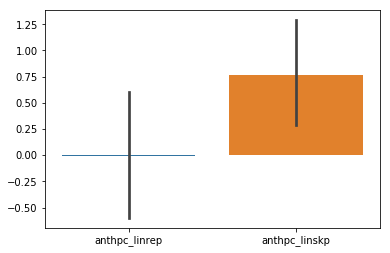

In [7]:
import seaborn as sns
ax = sns.barplot(data=all_data_df[['anthpc_linrep', 'anthpc_linskp']])
stats.ttest_rel(all_data_df['anthpc_linrep'], all_data_df['anthpc_linskp'])

-0.01030378184608511
0.7663642045211148
0.01030378184608511
-0.7663642045211148


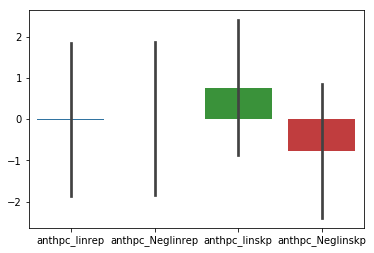

In [8]:
print all_data_df['anthpc_linrep'].mean()
print all_data_df['anthpc_linskp'].mean()
print all_data_df['anthpc_Neglinrep'].mean()
print all_data_df['anthpc_Neglinskp'].mean()
ax = sns.barplot(data=all_data_df[['anthpc_linrep', 'anthpc_Neglinrep', 'anthpc_linskp','anthpc_Neglinskp']], ci="sd")

In [9]:
print all_data_df['anthpc_linrep'].sem()
print all_data_df['anthpc_linskp'].sem()
print all_data_df['anthpc_Neglinrep'].sem()
print all_data_df['anthpc_Neglinskp'].sem()

0.3095308433231092
0.2717352979930549
0.3095308433231092
0.2717352979930549


In [10]:
print "paired ttest between neglinrep and linskp"
print stats.ttest_rel(all_data_df['anthpc_Neglinrep'], all_data_df['anthpc_linskp'])
print "paired ttest between linrep and linskp"
print stats.ttest_rel(all_data_df['anthpc_linrep'], all_data_df['anthpc_linskp'])
print "paired ttest between neglinskp and linskp"
print stats.ttest_rel(all_data_df['anthpc_Neglinskp'], all_data_df['anthpc_linskp'])

paired ttest between neglinrep and linskp
Ttest_relResult(statistic=-1.7225772901956153, pvalue=0.09354690005997535)
paired ttest between linrep and linskp
Ttest_relResult(statistic=-2.0280902441247353, pvalue=0.05000040228937466)
paired ttest between neglinskp and linskp
Ttest_relResult(statistic=-2.820260047852531, pvalue=0.007756152932541404)


In [14]:
print stats.ttest_1samp(all_data_df['anthpc_linskp'], 0)
print stats.ttest_1samp(all_data_df['anthpc_Neglinskp'], 0)
print stats.ttest_1samp(all_data_df['anthpc_linrep'], 0)
print stats.ttest_1samp(all_data_df['anthpc_Neglinrep'], 0)

Ttest_1sampResult(statistic=2.820260047852531, pvalue=0.007756152932541404)
Ttest_1sampResult(statistic=-2.820260047852531, pvalue=0.007756152932541404)
Ttest_1sampResult(statistic=-0.033288384884246666, pvalue=0.9736285013886139)
Ttest_1sampResult(statistic=0.033288384884246666, pvalue=0.9736285013886139)


Ttest_relResult(statistic=2.040744936196918, pvalue=0.05080566936823104)

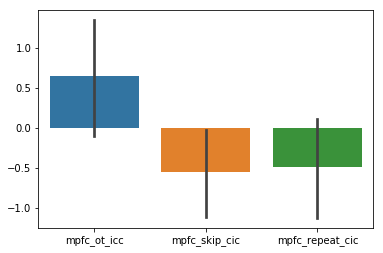

In [10]:
import seaborn as sns
all_data_df_nonan = all_data_df.drop(['783125', '783129', '783134', '783140', '783145', '783156', '783161', '783162'])
ax = sns.barplot(data=all_data_df_nonan[['mpfc_ot_icc', 'mpfc_skip_cic', 'mpfc_repeat_cic']])
stats.ttest_rel(all_data_df_nonan['mpfc_ot_icc'], all_data_df_nonan['mpfc_skip_cic'])

In [9]:
all_data_df

,anthpc_linrep,anthpc_linskp,mpfc_ot_icc,mpfc_repeat_cic,mpfc_skip_cic,subjid
783125,-0.988995,0.765899,NaN,-0.247409,-2.470777,783125
783126,0.637150,-2.927037,3.231153,0.167861,-2.687664,783126
783127,1.399733,-1.305027,0.677560,0.113470,-1.185903,783127
783128,-0.941571,-0.094342,-0.658121,-2.586713,1.758260,783128
783129,-1.993100,1.926620,1.594920,NaN,-2.195879,783129
783130,-2.868187,3.989777,2.791681,0.922788,-1.913363,783130
783131,0.757758,2.842944,3.643683,1.010150,0.508372,783131
783132,-0.048465,-0.235107,1.587440,-0.213903,-1.779814,783132
783133,-1.204172,3.110952,1.950312,-4.850558,-1.556841,783133
783134,-0.589505,0.137730,NaN,0.983402,-0.204975,783134


In [132]:
high_ot_df.to_csv('/home/data/madlab/data/mri/seqtrd/scndlvl/high_ot_betaval.csv')

# Next we look at subjects with low OT accuracy

In [133]:
#sids that dont have copes: 783129, 783131, 783143, 783158, 783162(doesnt have repeat corr or skip corr)
#sids without repeat incorrect copes: 783128, 783140, 783141, 783156, 783159
#sids without OT correct copes: 783125, 783134, 783142, 783147, 783151, 783154, 783157

#Next we look at the copes for position matched
#sids = os.listdir('/home/data/madlab/data/mri/seqtrd/scndlvl/seqbl_posplus_corrincorr')

#sids with low ot accuracy
sids = ('783130','783132','783133','783138','783139',
        '783141','783144','783145','783146','783152') 
        #no copes:'783131','783162'
        #no ot corr:'783125','783134','783142','783147','783151','783154','783157'

#sids with high ot accuracy
#sids = ('783126','783127','783128','783135','783136','783137','783140',
#        '783148','783149','783150','783153','783155','783156',
#        '783159','783161') 
        #no copes:'783129','783143','783158',
        #783163 has crazy high numbers

In [134]:
proj_dir = '/home/data/madlab/data/mri/seqtrd'
 
#making cope variables
mask_filenames = []
cope_inseq_files = []
cope_skip_corr_files = []
cope_skip_incorr_files = []
cope_repeat_corr_files = []
cope_repeat_incorr_files = []
cope_ot_corr_files = []
cope_ot_incorr_files = []

#right now its grabbing the masks from the sink dir

for SID in sids:
    mask_filenames_glob = glob('/scratch/madlab/seqtrd/anatroi_sinkdir/' + SID + '/anat_masks/*/*')
    mask_filenames.append(mask_filenames_glob)   
    
    #In pos
    curr_inseq_filenames_glob = glob(proj_dir + '/scndlvl/seqbl_posplus_corrincorr/' + SID + '/seq_pos_bl/fixedfx/cope_inseq_matchedpos.nii.gz')
    cope_inseq_files.append(curr_inseq_filenames_glob)       
    
    #Skip correct pos
    curr_skip_corr_filenames_glob = glob(proj_dir + '/scndlvl/seqbl_posplus_corrincorr/' + SID + '/seq_pos_bl/fixedfx/cope_skip_corr_pos.nii.gz')
    cope_skip_corr_files.append(curr_skip_corr_filenames_glob)
    
    #Skip incorrect pos
    curr_skip_incorr_filenames_glob = glob(proj_dir + '/scndlvl/seqbl_posplus_corrincorr/' + SID + '/seq_pos_bl/fixedfx/cope_skip_incorr_pos.nii.gz')
    cope_skip_incorr_files.append(curr_skip_incorr_filenames_glob)

    #Repeats correct pos
    curr_repeat_corr_filenames_glob = glob(proj_dir + '/scndlvl/seqbl_posplus_corrincorr/' + SID + '/seq_pos_bl/fixedfx/cope_repeat_corr_pos.nii.gz')
    cope_repeat_corr_files.append(curr_repeat_corr_filenames_glob)
    
    #Repeats incorrect pos
    curr_repeat_incorr_filenames_glob = glob(proj_dir + '/scndlvl/seqbl_posplus_corrincorr/' + SID + '/seq_pos_bl/fixedfx/cope_repeat_incorr_pos.nii.gz')
    cope_repeat_incorr_files.append(curr_repeat_incorr_filenames_glob)

    #Ordinal transfers correct pos (not one of the copes for some reason)
    curr_ot_corr_filenames_glob = glob(proj_dir + '/scndlvl/seqbl_posplus_corrincorr/' + SID + '/seq_pos_bl/fixedfx/cope_ot_corr_pos.nii.gz')
    cope_ot_corr_files.append(curr_ot_corr_filenames_glob)

    #Ordinal transfers correct pos
    curr_ot_incorr_filenames_glob = glob(proj_dir + '/scndlvl/seqbl_posplus_corrincorr/' + SID + '/seq_pos_bl/fixedfx/cope_ot_incorr_pos.nii.gz')
    cope_ot_incorr_files.append(curr_ot_incorr_filenames_glob)

In [135]:
all_data = {'subjid':[], 'anthpc_inseq':[],'anthpc_skip_corr':[],'anthpc_skip_incorr':[],'anthpc_repeat_corr':[],
            'anthpc_ot_incorr':[],
            'mpfc_inseq':[],'mpfc_skip_corr':[],'mpfc_skip_incorr':[],'mpfc_repeat_corr':[],
            'mpfc_ot_incorr':[],
            'rerh_inseq':[],'rerh_skip_corr':[],'rerh_skip_incorr':[],'rerh_repeat_corr':[],
            'rerh_ot_incorr':[],
            'pvpt_inseq':[],'pvpt_skip_corr':[],'pvpt_skip_incorr':[],'pvpt_repeat_corr':[],
            'pvpt_ot_incorr':[],
           'anthpc_ot_corr':[], 'mpfc_ot_corr':[],'rerh_ot_corr':[],'pvpt_ot_corr':[],}
#            'anthpc_repeat_incorr':[], 'mpfc_repeat_incorr':[],'rerh_repeat_incorr':[],'pvpt_repeat_incorr':[],

for i in range(len(sids)):
    all_data['subjid'].append(sids[i])
    
    #What are these numbers? They come from the cell before from glob. The mpfc for example is the second one in the list.
    #and the left anthpc is the 5th one in the list as you can se a
    currsubj_l_anthpc_img = nib.load(mask_filenames[i][4])
    currsubj_r_anthpc_img = nib.load(mask_filenames[i][5])
    currsubj_l_posthpc_img = nib.load(mask_filenames[i][6])
    currsubj_r_posthpc_img = nib.load(mask_filenames[i][3]) 
    currsubj_mpfc_img = nib.load(mask_filenames[i][1])
    currsubj_rerh_img = nib.load(mask_filenames[i][9])
    currsubj_pvpt_img = nib.load(mask_filenames[i][8])
    currsubj_limbicthal_img = nib.load(mask_filenames[i][7])
    currsubj_inseq_img = nib.load(cope_inseq_files[i][0])
    currsubj_skip_corr_img = nib.load(cope_skip_corr_files[i][0])
    currsubj_skip_incorr_img = nib.load(cope_skip_incorr_files[i][0])
    currsubj_repeat_corr_img = nib.load(cope_repeat_corr_files[i][0])
#    currsubj_repeat_incorr_img = nib.load(cope_repeat_incorr_files[i][0])
    currsubj_ot_corr_img = nib.load(cope_ot_corr_files[i][0])
    currsubj_ot_incorr_img = nib.load(cope_ot_incorr_files[i][0])
    
    
    #Here nibabel converts 3D or 4D data into a numpy array
    #getting functional data within the mask
    #left anterior hpc
    currsubj_anthpc_inseq_data = currsubj_inseq_img.get_data()[currsubj_anthpc_img.get_data() > 0.]
    all_data['anthpc_inseq'].append(np.mean(currsubj_anthpc_inseq_data))
    currsubj_anthpc_skip_corr_data = currsubj_skip_corr_img.get_data()[currsubj_anthpc_img.get_data() > 0.]
    all_data['anthpc_skip_corr'].append(np.mean(currsubj_anthpc_skip_corr_data))
    currsubj_anthpc_skip_incorr_data = currsubj_skip_incorr_img.get_data()[currsubj_anthpc_img.get_data() > 0.]
    all_data['anthpc_skip_incorr'].append(np.mean(currsubj_anthpc_skip_incorr_data))
    currsubj_anthpc_repeat_corr_data = currsubj_repeat_corr_img.get_data()[currsubj_anthpc_img.get_data() > 0.]
    all_data['anthpc_repeat_corr'].append(np.mean(currsubj_anthpc_repeat_corr_data))
#    currsubj_anthpc_repeat_incorr_data = currsubj_repeat_incorr_img.get_data()[currsubj_anthpc_img.get_data() > 0.]
#    all_data['anthpc_repeat_incorr'].append(np.mean(currsubj_anthpc_repeat_incorr_data))    
    currsubj_anthpc_ot_corr_data = currsubj_ot_corr_img.get_data()[currsubj_anthpc_img.get_data() > 0.]
    all_data['anthpc_ot_corr'].append(np.mean(currsubj_anthpc_ot_corr_data))
    currsubj_anthpc_ot_incorr_data = currsubj_ot_incorr_img.get_data()[currsubj_anthpc_img.get_data() > 0.]
    all_data['anthpc_ot_incorr'].append(np.mean(currsubj_anthpc_ot_incorr_data))

    
    
    #mpfc
    currsubj_mpfc_inseq_data = currsubj_inseq_img.get_data()[currsubj_mpfc_img.get_data() > 0.]
    all_data['mpfc_inseq'].append(np.mean(currsubj_mpfc_inseq_data))
    currsubj_mpfc_skip_corr_data = currsubj_skip_corr_img.get_data()[currsubj_mpfc_img.get_data() > 0.]
    all_data['mpfc_skip_corr'].append(np.mean(currsubj_mpfc_skip_corr_data))
    currsubj_mpfc_skip_incorr_data = currsubj_skip_incorr_img.get_data()[currsubj_mpfc_img.get_data() > 0.]
    all_data['mpfc_skip_incorr'].append(np.mean(currsubj_mpfc_skip_incorr_data))
    currsubj_mpfc_repeat_corr_data = currsubj_repeat_corr_img.get_data()[currsubj_mpfc_img.get_data() > 0.]
    all_data['mpfc_repeat_corr'].append(np.mean(currsubj_mpfc_repeat_corr_data))
#    currsubj_mpfc_repeat_incorr_data = currsubj_repeat_incorr_img.get_data()[currsubj_mpfc_img.get_data() > 0.]
#    all_data['mpfc_repeat_incorr'].append(np.mean(currsubj_mpfc_repeat_incorr_data))    
    currsubj_mpfc_ot_corr_data = currsubj_ot_corr_img.get_data()[currsubj_mpfc_img.get_data() > 0.]
    all_data['mpfc_ot_corr'].append(np.mean(currsubj_mpfc_ot_corr_data))
    currsubj_mpfc_ot_incorr_data = currsubj_ot_incorr_img.get_data()[currsubj_mpfc_img.get_data() > 0.]
    all_data['mpfc_ot_incorr'].append(np.mean(currsubj_mpfc_ot_incorr_data))

    
    #rerh
    currsubj_rerh_inseq_data = currsubj_inseq_img.get_data()[currsubj_rerh_img.get_data() > 0.]
    all_data['rerh_inseq'].append(np.mean(currsubj_rerh_inseq_data))
    currsubj_rerh_skip_corr_data = currsubj_skip_corr_img.get_data()[currsubj_rerh_img.get_data() > 0.]
    all_data['rerh_skip_corr'].append(np.mean(currsubj_rerh_skip_corr_data))
    currsubj_rerh_skip_incorr_data = currsubj_skip_incorr_img.get_data()[currsubj_rerh_img.get_data() > 0.]
    all_data['rerh_skip_incorr'].append(np.mean(currsubj_rerh_skip_incorr_data))
    currsubj_rerh_repeat_corr_data = currsubj_repeat_corr_img.get_data()[currsubj_rerh_img.get_data() > 0.]
    all_data['rerh_repeat_corr'].append(np.mean(currsubj_rerh_repeat_corr_data))
#    currsubj_rerh_repeat_incorr_data = currsubj_repeat_incorr_img.get_data()[currsubj_rerh_img.get_data() > 0.]
#    all_data['rerh_repeat_incorr'].append(np.mean(currsubj_rerh_repeat_incorr_data))    
    currsubj_rerh_ot_corr_data = currsubj_ot_corr_img.get_data()[currsubj_rerh_img.get_data() > 0.]
    all_data['rerh_ot_corr'].append(np.mean(currsubj_rerh_ot_corr_data))
    currsubj_rerh_ot_incorr_data = currsubj_ot_incorr_img.get_data()[currsubj_rerh_img.get_data() > 0.]
    all_data['rerh_ot_incorr'].append(np.mean(currsubj_rerh_ot_incorr_data))    

    #pvpt
    currsubj_pvpt_inseq_data = currsubj_inseq_img.get_data()[currsubj_pvpt_img.get_data() > 0.]
    all_data['pvpt_inseq'].append(np.mean(currsubj_pvpt_inseq_data))
    currsubj_pvpt_skip_corr_data = currsubj_skip_corr_img.get_data()[currsubj_pvpt_img.get_data() > 0.]
    all_data['pvpt_skip_corr'].append(np.mean(currsubj_pvpt_skip_corr_data))
    currsubj_pvpt_skip_incorr_data = currsubj_skip_incorr_img.get_data()[currsubj_pvpt_img.get_data() > 0.]
    all_data['pvpt_skip_incorr'].append(np.mean(currsubj_pvpt_skip_incorr_data))
    currsubj_pvpt_repeat_corr_data = currsubj_repeat_corr_img.get_data()[currsubj_pvpt_img.get_data() > 0.]
    all_data['pvpt_repeat_corr'].append(np.mean(currsubj_pvpt_repeat_corr_data))
#    currsubj_pvpt_repeat_incorr_data = currsubj_repeat_incorr_img.get_data()[currsubj_pvpt_img.get_data() > 0.]
#    all_data['pvpt_repeat_incorr'].append(np.mean(currsubj_pvpt_repeat_incorr_data))    
    currsubj_pvpt_ot_corr_data = currsubj_ot_corr_img.get_data()[currsubj_pvpt_img.get_data() > 0.]
    all_data['pvpt_ot_corr'].append(np.mean(currsubj_pvpt_ot_corr_data))
    currsubj_pvpt_ot_incorr_data = currsubj_ot_incorr_img.get_data()[currsubj_pvpt_img.get_data() > 0.]
    all_data['pvpt_ot_incorr'].append(np.mean(currsubj_pvpt_ot_incorr_data)) 

In [136]:
low_ot_df = pd.DataFrame(all_data)
low_ot_df.index = sids

In [137]:
low_ot_df

,anthpc_inseq,anthpc_ot_corr,anthpc_ot_incorr,anthpc_repeat_corr,anthpc_skip_corr,anthpc_skip_incorr,mpfc_inseq,mpfc_ot_corr,mpfc_ot_incorr,mpfc_repeat_corr,...,pvpt_repeat_corr,pvpt_skip_corr,pvpt_skip_incorr,rerh_inseq,rerh_ot_corr,rerh_ot_incorr,rerh_repeat_corr,rerh_skip_corr,rerh_skip_incorr,subjid
783130,-0.569230,-1.131578,0.029354,-0.354354,-0.298224,-1.282371,-1.385226,-4.340369,-0.714882,-0.877820,...,-2.131849,0.150069,-0.958784,-1.712927,0.248817,-2.597472,-2.208725,0.856890,-1.201633,783130
783132,-0.038027,0.316345,1.161569,-0.686004,-0.643286,0.004909,-0.319833,0.335588,2.773079,-2.978576,...,1.335561,1.172654,2.525279,0.298581,4.348937,4.087169,-0.858292,-0.874622,1.649303,783132
783133,2.668854,5.395845,2.624428,2.185681,0.110457,-1.214044,-4.730172,-2.405044,-5.359754,-3.920120,...,2.116406,0.079839,1.922976,-0.933520,0.191518,3.217880,1.085758,-5.123220,-3.408029,783133
783138,-2.345757,-4.570846,-4.321610,-2.500429,-2.687898,-2.577886,-3.684664,-6.570590,-3.848443,-3.758706,...,1.609763,-0.915200,6.186762,-5.315448,-8.109379,-8.924249,-6.680543,-7.816124,-4.103402,783138
783139,0.379560,-0.033131,1.011021,0.605443,1.303487,0.115971,-0.306895,0.030580,-3.229650,-0.741257,...,-2.626175,1.900396,2.111567,-0.723161,-0.053428,0.523295,-2.722426,1.179392,-1.003876,783139
783141,-0.312526,-0.870515,-1.504915,-0.129508,-0.527270,-0.238137,-1.349660,-9.584862,-5.756741,-1.057184,...,-2.282183,-2.721208,-1.224255,-0.942696,-6.822136,-5.500748,-0.801904,-2.266964,2.113799,783141
783144,-0.174921,0.504639,-0.000004,0.846340,0.746356,-0.248304,-3.111610,-2.999470,-0.000029,-3.124832,...,0.023424,1.445805,-1.443875,0.871807,-0.292051,0.000015,0.302482,3.352460,1.942296,783144
783145,-3.344243,-5.091786,-2.076649,-5.828310,-2.456811,-3.632056,-0.995686,7.652109,0.601890,-6.268552,...,-23.304728,-15.235096,-19.417599,-9.839629,-22.080549,-14.846941,-12.627794,-15.451594,-10.233084,783145
783146,-0.613519,-0.983840,1.427603,0.582376,-1.651229,-1.372255,-1.583467,-4.357039,3.030178,-3.804418,...,-1.802443,-2.389024,-2.348729,1.168634,3.878479,8.779943,0.052282,-0.433181,-0.029279,783146
783152,0.325214,0.358773,0.254545,0.160246,0.516326,0.245972,-3.371035,-0.612623,-1.892149,-3.970551,...,-3.175721,-3.791314,-5.121943,-4.884710,-3.544374,-4.289082,-7.028446,-5.522295,-5.534180,783152


In [138]:
low_ot_df.to_csv('/home/data/madlab/data/mri/seqtrd/scndlvl/low_ot_betaval.csv')

In [139]:
#sids that dont have copes: 783129, 783131, 783143, 783158, 783162(doesnt have repeat corr or skip corr)
#sids without repeat incorrect copes: 783128, 783140, 783141, 783156, 783159
#sids without OT correct copes: 783125, 783134, 783142, 783147, 783151, 783154, 783157

#Next we look at the copes for position matched
#sids = os.listdir('/home/data/madlab/data/mri/seqtrd/scndlvl/seqbl_posplus_corrincorr')

#sids with low ot accuracy
#sids = ('783130','783132','783133','783138','783139',
#        '783141','783144','783145','783146','783152') 
        #no copes:'783131','783162'
        #no ot corr:
sids = ('783125','783134','783142','783147','783151','783154','783157')

#sids with high ot accuracy
#sids = ('783126','783127','783128','783135','783136','783137','783140',
#        '783148','783149','783150','783153','783155','783156',
#        '783159','783161') 
        #no copes:'783129','783143','783158',
        #783163 has crazy high numbers

In [140]:
proj_dir = '/home/data/madlab/data/mri/seqtrd'
 
#making cope variables
mask_filenames = []
cope_inseq_files = []
cope_skip_corr_files = []
cope_skip_incorr_files = []
cope_repeat_corr_files = []
cope_repeat_incorr_files = []
cope_ot_corr_files = []
cope_ot_incorr_files = []

#right now its grabbing the masks from the sink dir

for SID in sids:
    mask_filenames_glob = glob('/scratch/madlab/seqtrd/anatroi_sinkdir/' + SID + '/anat_masks/*/*')
    mask_filenames.append(mask_filenames_glob)   
    
    #In pos
    curr_inseq_filenames_glob = glob(proj_dir + '/scndlvl/seqbl_posplus_corrincorr/' + SID + '/seq_pos_bl/fixedfx/cope_inseq_matchedpos.nii.gz')
    cope_inseq_files.append(curr_inseq_filenames_glob)       
    
    #Skip correct pos
    curr_skip_corr_filenames_glob = glob(proj_dir + '/scndlvl/seqbl_posplus_corrincorr/' + SID + '/seq_pos_bl/fixedfx/cope_skip_corr_pos.nii.gz')
    cope_skip_corr_files.append(curr_skip_corr_filenames_glob)
    
    #Skip incorrect pos
    curr_skip_incorr_filenames_glob = glob(proj_dir + '/scndlvl/seqbl_posplus_corrincorr/' + SID + '/seq_pos_bl/fixedfx/cope_skip_incorr_pos.nii.gz')
    cope_skip_incorr_files.append(curr_skip_incorr_filenames_glob)

    #Repeats correct pos
    curr_repeat_corr_filenames_glob = glob(proj_dir + '/scndlvl/seqbl_posplus_corrincorr/' + SID + '/seq_pos_bl/fixedfx/cope_repeat_corr_pos.nii.gz')
    cope_repeat_corr_files.append(curr_repeat_corr_filenames_glob)
    
    #Repeats incorrect pos
    curr_repeat_incorr_filenames_glob = glob(proj_dir + '/scndlvl/seqbl_posplus_corrincorr/' + SID + '/seq_pos_bl/fixedfx/cope_repeat_incorr_pos.nii.gz')
    cope_repeat_incorr_files.append(curr_repeat_incorr_filenames_glob)

    #Ordinal transfers correct pos (not one of the copes for some reason)
    curr_ot_corr_filenames_glob = glob(proj_dir + '/scndlvl/seqbl_posplus_corrincorr/' + SID + '/seq_pos_bl/fixedfx/cope_ot_corr_pos.nii.gz')
    cope_ot_corr_files.append(curr_ot_corr_filenames_glob)

    #Ordinal transfers correct pos
    curr_ot_incorr_filenames_glob = glob(proj_dir + '/scndlvl/seqbl_posplus_corrincorr/' + SID + '/seq_pos_bl/fixedfx/cope_ot_incorr_pos.nii.gz')
    cope_ot_incorr_files.append(curr_ot_incorr_filenames_glob)

In [141]:
mask_filenames_glob

['/scratch/madlab/seqtrd/anatroi_sinkdir/783157/anat_masks/_subject_id_783157/post_hpc_bimask_warped.nii.gz',
 '/scratch/madlab/seqtrd/anatroi_sinkdir/783157/anat_masks/_subject_id_783157/mpfc_bimask_warped.nii.gz',
 '/scratch/madlab/seqtrd/anatroi_sinkdir/783157/anat_masks/_subject_id_783157/ant_hpc_bimask_warped.nii.gz',
 '/scratch/madlab/seqtrd/anatroi_sinkdir/783157/anat_masks/_subject_id_783157/r_post_hpc_warped.nii.gz',
 '/scratch/madlab/seqtrd/anatroi_sinkdir/783157/anat_masks/_subject_id_783157/l_post_hpc_warped.nii.gz',
 '/scratch/madlab/seqtrd/anatroi_sinkdir/783157/anat_masks/_subject_id_783157/r_ant_hpc_warped.nii.gz',
 '/scratch/madlab/seqtrd/anatroi_sinkdir/783157/anat_masks/_subject_id_783157/l_ant_hpc_warped.nii.gz',
 '/scratch/madlab/seqtrd/anatroi_sinkdir/783157/anat_masks/_subject_id_783157/limbicthal_bin_trans_warped.nii.gz',
 '/scratch/madlab/seqtrd/anatroi_sinkdir/783157/anat_masks/_subject_id_783157/PV_thal_only_trans_warped.nii.gz',
 '/scratch/madlab/seqtrd/anat

In [142]:
all_data = {'subjid':[], 'anthpc_inseq':[],'anthpc_skip_corr':[],'anthpc_skip_incorr':[],'anthpc_repeat_corr':[],
            'anthpc_ot_incorr':[],
            'mpfc_inseq':[],'mpfc_skip_corr':[],'mpfc_skip_incorr':[],'mpfc_repeat_corr':[],
            'mpfc_ot_incorr':[],
            'rerh_inseq':[],'rerh_skip_corr':[],'rerh_skip_incorr':[],'rerh_repeat_corr':[],
            'rerh_ot_incorr':[],
            'pvpt_inseq':[],'pvpt_skip_corr':[],'pvpt_skip_incorr':[],'pvpt_repeat_corr':[],
            'pvpt_ot_incorr':[]}
#           'anthpc_ot_corr':[], 'mpfc_ot_corr':[],'rerh_ot_corr':[],'pvpt_ot_corr':[],}
#            'anthpc_repeat_incorr':[], 'mpfc_repeat_incorr':[],'rerh_repeat_incorr':[],'pvpt_repeat_incorr':[],

for i in range(len(sids)):
    all_data['subjid'].append(sids[i])
    
    #What are these numbers? They come from the cell before from glob. The mpfc for example is the second one in the list.
    #and the left anthpc is the 5th one in the list as you can se a
    currsubj_mpfc_img = nib.load(mask_filenames[i][1])
    currsubj_r_posthpc_img = nib.load(mask_filenames[i][3])
    currsubj_l_anthpc_img = nib.load(mask_filenames[i][4])
    currsubj_r_anthpc_img = nib.load(mask_filenames[i][5])
    currsubj_l_posthpc_img = nib.load(mask_filenames[i][6]) 
    currsubj_rerh_img = nib.load(mask_filenames[i][9])
    currsubj_pvpt_img = nib.load(mask_filenames[i][8])
    currsubj_limbicthal_img = nib.load(mask_filenames[i][7])
    currsubj_inseq_img = nib.load(cope_inseq_files[i][0])
    currsubj_skip_corr_img = nib.load(cope_skip_corr_files[i][0])
    currsubj_skip_incorr_img = nib.load(cope_skip_incorr_files[i][0])
    currsubj_repeat_corr_img = nib.load(cope_repeat_corr_files[i][0])
#    currsubj_repeat_incorr_img = nib.load(cope_repeat_incorr_files[i][0])
#    currsubj_ot_corr_img = nib.load(cope_ot_corr_files[i][0])
    currsubj_ot_incorr_img = nib.load(cope_ot_incorr_files[i][0])
    
    
    #Here nibabel converts 3D or 4D data into a numpy array
    #getting functional data within the mask
    #left anterior hpc
    currsubj_anthpc_inseq_data = currsubj_inseq_img.get_data()[currsubj_anthpc_img.get_data() > 0.]
    all_data['anthpc_inseq'].append(np.mean(currsubj_anthpc_inseq_data))
    currsubj_anthpc_skip_corr_data = currsubj_skip_corr_img.get_data()[currsubj_anthpc_img.get_data() > 0.]
    all_data['anthpc_skip_corr'].append(np.mean(currsubj_anthpc_skip_corr_data))
    currsubj_anthpc_skip_incorr_data = currsubj_skip_incorr_img.get_data()[currsubj_anthpc_img.get_data() > 0.]
    all_data['anthpc_skip_incorr'].append(np.mean(currsubj_anthpc_skip_incorr_data))
    currsubj_anthpc_repeat_corr_data = currsubj_repeat_corr_img.get_data()[currsubj_anthpc_img.get_data() > 0.]
    all_data['anthpc_repeat_corr'].append(np.mean(currsubj_anthpc_repeat_corr_data))
#    currsubj_anthpc_repeat_incorr_data = currsubj_repeat_incorr_img.get_data()[currsubj_anthpc_img.get_data() > 0.]
#    all_data['anthpc_repeat_incorr'].append(np.mean(currsubj_anthpc_repeat_incorr_data))    
#    currsubj_anthpc_ot_corr_data = currsubj_ot_corr_img.get_data()[currsubj_anthpc_img.get_data() > 0.]
#    all_data['anthpc_ot_corr'].append(np.mean(currsubj_anthpc_ot_corr_data))
    currsubj_anthpc_ot_incorr_data = currsubj_ot_incorr_img.get_data()[currsubj_anthpc_img.get_data() > 0.]
    all_data['anthpc_ot_incorr'].append(np.mean(currsubj_anthpc_ot_incorr_data))

    
    
    #mpfc
    currsubj_mpfc_inseq_data = currsubj_inseq_img.get_data()[currsubj_mpfc_img.get_data() > 0.]
    all_data['mpfc_inseq'].append(np.mean(currsubj_mpfc_inseq_data))
    currsubj_mpfc_skip_corr_data = currsubj_skip_corr_img.get_data()[currsubj_mpfc_img.get_data() > 0.]
    all_data['mpfc_skip_corr'].append(np.mean(currsubj_mpfc_skip_corr_data))
    currsubj_mpfc_skip_incorr_data = currsubj_skip_incorr_img.get_data()[currsubj_mpfc_img.get_data() > 0.]
    all_data['mpfc_skip_incorr'].append(np.mean(currsubj_mpfc_skip_incorr_data))
    currsubj_mpfc_repeat_corr_data = currsubj_repeat_corr_img.get_data()[currsubj_mpfc_img.get_data() > 0.]
    all_data['mpfc_repeat_corr'].append(np.mean(currsubj_mpfc_repeat_corr_data))
#    currsubj_mpfc_repeat_incorr_data = currsubj_repeat_incorr_img.get_data()[currsubj_mpfc_img.get_data() > 0.]
#    all_data['mpfc_repeat_incorr'].append(np.mean(currsubj_mpfc_repeat_incorr_data))    
 #   currsubj_mpfc_ot_corr_data = currsubj_ot_corr_img.get_data()[currsubj_mpfc_img.get_data() > 0.]
#    all_data['mpfc_ot_corr'].append(np.mean(currsubj_mpfc_ot_corr_data))
    currsubj_mpfc_ot_incorr_data = currsubj_ot_incorr_img.get_data()[currsubj_mpfc_img.get_data() > 0.]
    all_data['mpfc_ot_incorr'].append(np.mean(currsubj_mpfc_ot_incorr_data))

    
    #rerh
    currsubj_rerh_inseq_data = currsubj_inseq_img.get_data()[currsubj_rerh_img.get_data() > 0.]
    all_data['rerh_inseq'].append(np.mean(currsubj_rerh_inseq_data))
    currsubj_rerh_skip_corr_data = currsubj_skip_corr_img.get_data()[currsubj_rerh_img.get_data() > 0.]
    all_data['rerh_skip_corr'].append(np.mean(currsubj_rerh_skip_corr_data))
    currsubj_rerh_skip_incorr_data = currsubj_skip_incorr_img.get_data()[currsubj_rerh_img.get_data() > 0.]
    all_data['rerh_skip_incorr'].append(np.mean(currsubj_rerh_skip_incorr_data))
    currsubj_rerh_repeat_corr_data = currsubj_repeat_corr_img.get_data()[currsubj_rerh_img.get_data() > 0.]
    all_data['rerh_repeat_corr'].append(np.mean(currsubj_rerh_repeat_corr_data))
#    currsubj_rerh_repeat_incorr_data = currsubj_repeat_incorr_img.get_data()[currsubj_rerh_img.get_data() > 0.]
#    all_data['rerh_repeat_incorr'].append(np.mean(currsubj_rerh_repeat_incorr_data))    
 #   currsubj_rerh_ot_corr_data = currsubj_ot_corr_img.get_data()[currsubj_rerh_img.get_data() > 0.]
#    all_data['rerh_ot_corr'].append(np.mean(currsubj_rerh_ot_corr_data))
    currsubj_rerh_ot_incorr_data = currsubj_ot_incorr_img.get_data()[currsubj_rerh_img.get_data() > 0.]
    all_data['rerh_ot_incorr'].append(np.mean(currsubj_rerh_ot_incorr_data))    

    #pvpt
    currsubj_pvpt_inseq_data = currsubj_inseq_img.get_data()[currsubj_pvpt_img.get_data() > 0.]
    all_data['pvpt_inseq'].append(np.mean(currsubj_pvpt_inseq_data))
    currsubj_pvpt_skip_corr_data = currsubj_skip_corr_img.get_data()[currsubj_pvpt_img.get_data() > 0.]
    all_data['pvpt_skip_corr'].append(np.mean(currsubj_pvpt_skip_corr_data))
    currsubj_pvpt_skip_incorr_data = currsubj_skip_incorr_img.get_data()[currsubj_pvpt_img.get_data() > 0.]
    all_data['pvpt_skip_incorr'].append(np.mean(currsubj_pvpt_skip_incorr_data))
    currsubj_pvpt_repeat_corr_data = currsubj_repeat_corr_img.get_data()[currsubj_pvpt_img.get_data() > 0.]
    all_data['pvpt_repeat_corr'].append(np.mean(currsubj_pvpt_repeat_corr_data))
#    currsubj_pvpt_repeat_incorr_data = currsubj_repeat_incorr_img.get_data()[currsubj_pvpt_img.get_data() > 0.]
#    all_data['pvpt_repeat_incorr'].append(np.mean(currsubj_pvpt_repeat_incorr_data))    
 #   currsubj_pvpt_ot_corr_data = currsubj_ot_corr_img.get_data()[currsubj_pvpt_img.get_data() > 0.]
#    all_data['pvpt_ot_corr'].append(np.mean(currsubj_pvpt_ot_corr_data))
    currsubj_pvpt_ot_incorr_data = currsubj_ot_incorr_img.get_data()[currsubj_pvpt_img.get_data() > 0.]
    all_data['pvpt_ot_incorr'].append(np.mean(currsubj_pvpt_ot_incorr_data)) 

In [143]:
lowest_ot_df = pd.DataFrame(all_data)
lowest_ot_df.index = sids

In [144]:
lowest_ot_df

,anthpc_inseq,anthpc_ot_incorr,anthpc_repeat_corr,anthpc_skip_corr,anthpc_skip_incorr,mpfc_inseq,mpfc_ot_incorr,mpfc_repeat_corr,mpfc_skip_corr,mpfc_skip_incorr,...,pvpt_ot_incorr,pvpt_repeat_corr,pvpt_skip_corr,pvpt_skip_incorr,rerh_inseq,rerh_ot_incorr,rerh_repeat_corr,rerh_skip_corr,rerh_skip_incorr,subjid
783125,-0.662822,0.052890,-1.112876,-1.262727,-2.071614,-0.740751,-2.576892,-3.395043,-4.418417,0.135360,...,-0.319835,-1.443719,-1.970989,-0.036649,-1.720293,-0.875568,-0.725633,-5.739645,-0.238315,783125
783134,-0.170318,-0.843530,2.052370,0.332648,-1.002560,2.148430,3.698054,-2.759556,-1.215938,-2.193260,...,-1.281229,-4.986765,-2.448249,-3.920680,-2.720359,-1.042279,-4.032726,-3.509168,-3.982827,783134
783142,-2.164126,-5.681877,-0.918505,0.963602,-2.028974,-4.424182,-15.978964,1.933441,0.764408,-3.251278,...,-11.215587,1.205971,1.652746,-0.627640,-1.657646,-9.403377,0.914457,2.241386,0.836748,783142
783147,-1.369024,-1.984297,-1.407796,-0.646960,-1.083731,-3.693355,-5.422295,-3.266290,-1.965450,0.112599,...,-5.931731,-1.936490,0.814924,-0.160472,-2.398149,-3.973456,-0.331782,-1.012745,-1.738767,783147
783151,0.507240,-0.019145,1.940555,0.294966,1.352687,-1.000424,1.402262,-0.991956,-0.674872,0.510479,...,3.871256,3.563126,2.627545,4.921635,2.747635,1.059648,4.895688,3.422559,6.221616,783151
783154,-0.795146,-1.573919,-1.156434,-1.276087,-1.093387,-1.964574,-2.192440,-2.431040,-4.235606,-2.956874,...,-4.065650,-0.461928,-1.661930,-0.690607,-2.055350,-3.152277,-1.671407,-1.141947,-2.218924,783154
783157,2.305380,4.272152,2.846773,-1.036331,0.948284,-0.014194,-3.615867,-3.968507,-5.553479,-0.056082,...,3.543033,-0.716785,-0.165169,0.309031,1.130972,2.249725,-2.133266,-0.826942,-0.223368,783157


In [145]:
lowest_ot_df.to_csv('/home/data/madlab/data/mri/seqtrd/scndlvl/lowest_ot_betaval.csv')